# Advanced droughts workflow

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/DROUGHTS/main?labpath=DROUGHTS_notebook_1.ipynb) to launch this workflow on MyBinder. 

This template workflow should help us make sure that all the notebooks have the same structure.  
The green 'tip' boxes are there with the example text. **Make sure you delete them when you add your own text**.

Useful links:

- [Jupyter book documentation](https://jupyterbook.org/en/stable/intro.html)
- [MyST Markdown documentation](https://myst-parser.readthedocs.io/en/latest/index.html)

## Risk assessment methodology

This methodology is for assessing drought risk and it is based on [Carrão et al. (2016)](https://doi.org/10.1016/j.gloenvcha.2016.04.012). This paper produced a risk map which indicates the probability of harmful consequences from the interactions (i.e., multiplication) between drought hazards, exposure, and vulnerability, by normalizing the regional scores to a scale ranging between zero to one (one indicating the highest drought risk). For the purposes of this toolbox, we plan to follow Carrão et al. (2016) work, reproducing the drought risk map for the European Union at NUTS2 spatial resolution, for both historical (1960 -2019), and future scenarios (2020 -2100).

### Drought hazard indices

Hazard indicators Drought hazard (dh) for a given region is estimated as the probability of exceedance the median of global severe precipitation deficits for an historical reference period (1960 -2019). [Carrão et al. (2016)](https://doi.org/10.1016/j.gloenvcha.2016.04.012) use the weighted anomaly of standardized precipitation (WASP) index to define the severity of precipitation deficit. The WASP-index takes into account the annual seasonality of precipitation cycle and is computed by summing weighted standardized monthly precipitation anomalies (Lyon and Barnston, 2005).

Daily global gridded climate related forcings are available from the GSWP3-W5E5 dataset (ISIMIP3a; ISIMIP Repository https://doi.org/10.48364/ISIMIP.982724.1) at a 0.5-degree spatial resolution, covering the years 1901 -2019. The period between 2020 -2100, will be covered by five different simulated biased-adjusted atmospheric climate (GFDL-ESM4, IPSL-CM6A-LR, MPI-ESM1-2-HR, MRI-ESM2-0, UKESM1-0-KK) and three different RCPs (2.6, 7.0, and 8.5).

### Drought exposure indices

A non-compensatory model of drought exposure is used to estimate the potential losses from different types of drought disasters at different geographic regions. It accounts for the spatial distribution of crop areas and livestock (agricultural drought), water stress (hydrological drought), and human population (socioeconomic drought). This approach defines highly exposed regions in case at least one type of asset is abundant. For that purpose, we will use data envelopment analysis (DEA), which determines the relative exposure of each region to drought by its statistical positioning and normalized multivariate distance to a performance frontier.

We will use the following datasets for the exposure indicator: • Gridded global cropland at 5 arc minutes resolution for 2010 (Spatial Production and Allocation model; IFPRI, 2019 https://doi.org/10.7910/DVN/PRFF8V). • Gridded global livestock density at 5 arc minutes resolution for 2010 (The global gridded livestock of the world, GLW; Gilbert et al., 2018 https://data.apps.fao.org/catalog/dataset/glw). • Global sub-basin scale/gridded baseline water stress (BWS) can be taken as an historical average from Aqueduct 3 (source https://doi.org/10.46830/writn.18.00146) or calculated based on the Global ISIMIP3 CWatM simulations (Burek et al., 2020). • Gridded global population at 2.5 arc minutes resolution for 2015 (the Gridded Population of the World; Doxsey-Whitfield, et al., 2015 https://doi.org/10.7927/H45Q4T5F).

### Drought vulnerability indices

Vulnerability to drought is computed as a 2-step composite model that derives from the aggregation of proxy indicators representing the economic, social, and infrastructural factors of vulnerability at each geographic location, as similar as for the Drought Vulnerability Index (DVI). A possible source for indicators can be World Bank https://data.worldbank.org/.

In the first step, indicators for each factor are combined using a DEA model, as similar as for drought exposure. In the second step, individual factors resulting from independent DEA analyses are arithmetically aggregated (using the simple mean) into a composite model of drought vulnerability (dv).

Describe where the data can be found, is there an API to download it or the files can be downloaded from some data repository. Provide a link to the repository (as DOI if possible).
wnload it or the files can be downloaded from some data repository. Provide a link to the repository (as DOI if possible).

## Preparation work

### Load libraries

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [pandas](https://pandas.pydata.org/docs/user_guide/index.html) - To create and manage data frames (tables) in Python
- [jenkspy](https://github.com/mthh/jenkspy) - To apply Fisher-Jenks alogrithm to classify drought/non-drought periods
- [numpy](https://numpy.org/doc/stable/) - For basic math tools and operations
- [matplotlib](https://matplotlib.org/) - For plotting


#### Template dep.

- [pooch](https://www.fatiando.org/pooch/latest/index.html) - To download and unzip the data
- [rasterio](https://rasterio.readthedocs.io/en/stable/) - To access and explore geospatial raster data in GeoTIFF format
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [rioxarray](https://corteva.github.io/rioxarray/stable/) - Rasterio xarray extension - to make it easier to use GeoTIFF data with xarray
- [damagescanner](https://damagescanner.readthedocs.io/en/latest/#) - To calculate the damage maps
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot the maps


In [1]:
import os
import pandas as pd
import jenkspy
import numpy as np
import matplotlib.pyplot as plt
import scipy


# adapted from https://github.com/metjush/envelopment-py/tree/master
from envelopmentpy.envelopment import *

'''
# template dependencies below.
import rasterio
from pathlib import Path
import rioxarray as rxr
import xarray as xr


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
'''

TabError: inconsistent use of tabs and spaces in indentation (envelopment.py, line 146)

### Define working environment
This workflow relies on pre-procssed data. The user will define the path to the data folder and the code below would create a folder for outputs.


In [1]:
workflow_folder = 'c:/users/artuso/Desktop/climaxx_droughts'
# debug if folder does not exist - issue an error to check path

# create outputs folder
if not os.path.exists(os.path.join(workflow_folder, 'outputs')):
    os.makedirs(os.path.join(workflow_folder, 'outputs'))

NameError: name 'os' is not defined

### Loading and visualizing hazard indices

Input precipitation data (top 3 rows): 
   timing  RID1  RID2  RID3
0  Jan-90   169   370   626
1  Feb-90   230   282   416
2  Mar-90   111   265   613


Input precipitation line chart: 


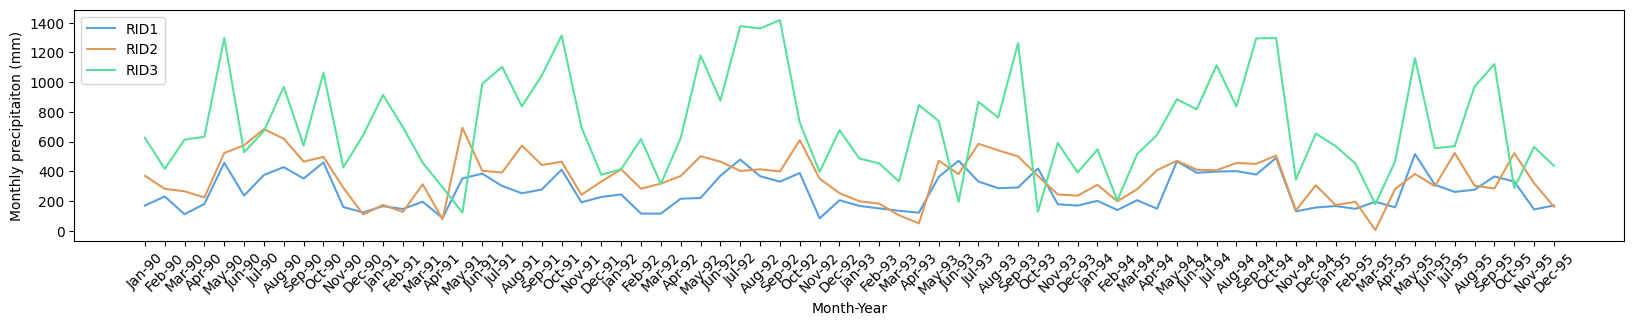



Hazard indices: 


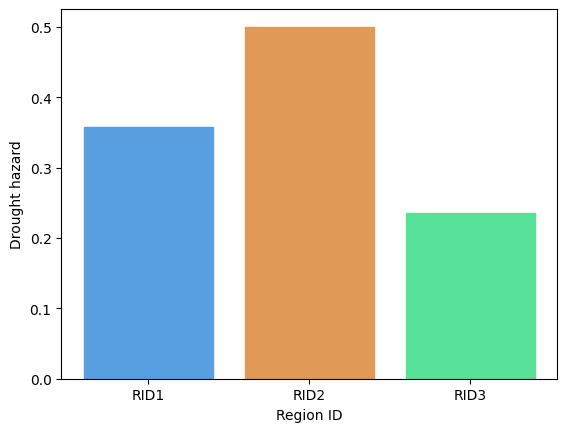

In [4]:
# Load precipitation data
precip = pd.read_csv(os.path.join(workflow_folder, "P_sample.csv"))


# show data

print('Input precipitation data (top 3 rows): ')
print(precip.head(3))

#plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
print('\n')
print('Input precipitation line chart: ')

rcolors = ['#579fe1', '#E19957', '#57e199']

plt.rcParams["figure.figsize"] = (20,3)
fig, ax = plt.subplots()
plt.xticks(rotation = 45) 

ax.plot(precip['timing'].tolist(), precip['RID1'].tolist(), label = 'RID1', color = rcolors[0])
ax.plot(precip['timing'].tolist(), precip['RID2'].tolist(), label = 'RID2', color = rcolors[1])
ax.plot(precip['timing'].tolist(), precip['RID3'].tolist(), label = 'RID3', color = rcolors[2])
ax.legend(loc = 'upper left')

plt.xlabel("Month-Year")
plt.ylabel("Monthly precipitaiton (mm)")

plt.show()

def calculate_monthly_threshold(x, m, col_idx):
    idx = (x['timing'].str.contains(m))
    mon_loc_subset = precip.iloc[idx[idx].index, col_idx]
    return(jenkspy.jenks_breaks(mon_loc_subset, n_classes = 2)[1])

def identify_monthly_drought(x, m, col_idx, thrs):
    idx = (x['timing'].str.contains(m))
    x.iloc[idx[idx].index, col_idx] = x.iloc[idx[idx].index, col_idx] < thrs
    return(x)

def identify_t_m(k, m):
    if 'Jan' in precip.iloc[k, 0]: 
        return(int(0))
    if 'Feb' in precip.iloc[k, 0]:
        return(int(1))
    if 'Mar' in precip.iloc[k, 0]:
        return(int(2))
    if 'Apr' in precip.iloc[k, 0]:
        return(int(3))
    if 'May' in precip.iloc[k, 0]:
        return(int(4))
    if 'Jun' in precip.iloc[k, 0]:
        return(int(5))
    if 'Jul' in precip.iloc[k, 0]:
        return(int(6))
    if 'Aug' in precip.iloc[k, 0]:
        return(int(7))
    if 'Sep' in precip.iloc[k, 0]:
        return(int(8))
    if 'Oct' in precip.iloc[k, 0]:
        return(int(9))
    if 'Nov' in precip.iloc[k, 0]:
        return(int(10))
    if 'Dec' in precip.iloc[k, 0]:
        return(int(11))


#def perform_WASP(x, m, col_idx):
    
## calculate WASP Index monthly threshold

WASP = []
WASP_global = []
### create a multi-dimensional array for monthly thresholds
monthString = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
drought_class = precip.copy()

# prepare output for drought event index - WASP_j- list of lists wasp = [[rid1], [rid2], ...]
for i in range(1, len(precip.columns)):
    t_m = []
    for mon_ in monthString:
        t_m_last = calculate_monthly_threshold(x = precip, m = mon_, col_idx = i)
        t_m.append(t_m_last)
        drought_class = identify_monthly_drought(x = drought_class, m = mon_, col_idx = i, thrs = t_m_last)
    # calculate annual threshold & count droughts
    t_a = sum(t_m)

    WASP_tmp = []
    first_true=0
    index = []
    for k in range(1, len(precip)):
        if drought_class.iloc[k, i]== 1:
            if first_true==0:                               
                index = identify_t_m(k = k, m = mon_)
                WASP_last=((precip.iloc[k,i] - t_m[index])/t_m[index])* (t_m[index]/t_a)
                WASP_tmp.append(WASP_last)
                first_true=1
            else:                         
                index_last = identify_t_m(k = k, m = mon_) 
                WASP_last=((precip.iloc[k,i] - t_m[index])/t_m[index])* (t_m[index]/t_a)
                WASP_tmp[-1]=WASP_tmp[-1] + WASP_last
            #print(WASP_last)
            WASP_global.append(WASP_last)
        else:
            first_true=0
    #print (WASP_tmp)
    WASP.append(np.array(WASP_tmp))
    
    
'''
    About WASP index: http://iridl.ldeo.columbia.edu/maproom/Global/Precipitation/WASP_Indices.html?bbox=bb%3A25.668%3A14.894%3A65.270%3A37.928%3Abb&T=Apr%202010
    
    WASP < 0 --> Dry
    WASP > 0 --> Wet
    
'''

# calculate the exceedance probability from the median global WASP as the Hazard index (dH)
dH = []
WASP = np.array(WASP, dtype=object)
# calculate global median deficit severity
median_global_wasp = np.nanmedian(WASP_global)

# calculate dH per region i
for i in range(WASP.shape[0]):
    dH.append(1 - np.nansum(WASP[i] <= median_global_wasp) / len(WASP[i]))

print('\n')
print('Hazard indices: ')


plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
barlist = plt.bar(['RID1', 'RID2', 'RID3'], dH)
for i in range(3):
    barlist[i].set_color(rcolors[i])
plt.xlabel("Region ID")
plt.ylabel("Drought hazard")

plt.show()



In [62]:
# Load exposure data
exposure = pd.read_csv(os.path.join(workflow_folder, "Exposure_sample.csv"))


# show data

print('Input exposure data (top 3 rows): ')
print(exposure)

# see tutorial dea: http://deazone.com/en/resources/tutorial/abstract
dea = DEA(exposure.to_numpy()[0:3, 1:4],\
          np.array([1000.,1000.,1000.]).reshape(3,1))
dea.name_units(['RID1', 'RID2', 'RID3'])
d = dea.fit(loud = true)  


Input exposure data (top 3 rows): 
  Country_Name   Exposure_1  Exposure_2  Exposure_3
0         RID1  1790.348800       10.52       33.62
1         RID2  2998.501158       32.74       52.33
2         RID3  6802.804519        5.53        9.05


NameError: name 'true' is not defined

In [36]:
# Load exposure data
vulnerability = pd.read_csv(os.path.join(workflow_folder, "Vulnerability_sample.csv"))


# show data

print('Input vulnerability data (top 3 rows): ')
print(vulnerability)

# see tutorial dea: http://deazone.com/en/resources/tutorial/abstract
# dea = DEA(exposure.to_numpy()[0:3, 1:4],\
#           np.array([1000.,1000.,1000.]).reshape(3,1))
# dea.name_units(['RID1', 'RID2', 'RID3'])
# dea.fit()




Input vulnerability data (top 3 rows): 
  Country_Name  Social_1  Social_2  Social_3  Economic_1  Economic_2  \
0         RID1   1820.34     37.98    546.45         313       65.36   
1         RID2   3552.20     25.25    694.25         171       47.36   
2         RID3   5241.98      5.55    983.47         158       25.39   

   Economic_3  Infrastructural_1  Infrastructural_2  Infrastructural_3  
0        0.25              30.25              54.25            4563.25  
1        0.49              70.36              65.36            4587.34  
2        0.36              23.01              47.65            8963.54  


In [34]:
# def identify_t_m(k, m):
#     if m in precip.iloc[k, 0]: 
#         return(monthString.index(m))

# for i in range(1, len(precip.columns)):
#     t_m = []
#     for mon_ in monthString:
#         t_m_last = calculate_monthly_threshold(x = precip, m = mon_, col_idx = i)
#         t_m.append(t_m_last)
#         drought_class = identify_monthly_drought(x = drought_class, m = mon_, col_idx = i, thrs = t_m_last)
#     # calculate annual threshold & count droughts
#     t_a = sum(t_m)
#     WASP = []
#     first_true=0
#     index = []
#     for k in range(1, len(precip)):
#         if drought_class.iloc[k, i]== 1:
#             if first_true==0:                               
#                 for mon_ in monthString:
#                     index_last = identify_t_m(k = k, m = mon_) 
#                     if index_last is not None:
#                         index.append(index_last)
#                 WASP_last=(precip.iloc[k,i]-t_m[index])/t_m[index]* (t_m[index]/t_a)
#                 WASP.append(WASP_last)
#                 first_true=1
#             else:                         
#                 for mon_ in monthString:
#                     index_last = identify_t_m(k = k, m = mon_) 
#                     if index_last is not None:
#                         index.append(index_last)
#                 WASP_last=(precip.iloc[k,i]-t_m[index])/t_m[index]* (t_m[index]/t_a)
#                 WASP[-1]=WASP[-1]+WASP_last
#         else:
#             first_true=0
#     print (WASP)

         



## TEMPLATE WORKFLOW BELOW

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'my_workflow' in the same directory where this notebook is saved.


:::{tip} Don't forget!
Replace **my_workflow** with the workflow name and delete this note
:::


In [86]:
workflow_folder = 'my_workflow'
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

### Download data

**You can keep the text below if you want to use pooch for downloading. Otherwise add a text about the API and delete the pooch bit.**

The data we are using is available as compressed ZIP files in the JRC data portal. 
Since there is no API to download this data, we can use **[pooch](https://www.fatiando.org/pooch/latest/index.html)** library to donwload and unzip the data.  

Pooch will check if the zip file already exists by comparing the hash of the file with what is stored in the default and only download it if it is not already there.

In [3]:
data_dir = os.path.join(workflow_folder,'data')

Note that now we have a directory **my_workflow/data** where all the zip files and unzipped flood files are.  
We can list all the files in the **data_dir** using the os library.  

In [ ]:
with os.scandir(data_dir) as entries:
    for entry in entries:
        print(entry.name)

#### First type of data
First we need the information on land use. We will download it from the JRC data portal.
:::{tip} Here's an example of the text and code
Once the data is downloaded and unzipped, Pooch will list the content of the directory with the data.

```python
url = 'https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/LUISA/PrimaryOutput/Europe/REF-2014/JRC_LUISA_Output_land_use_ref_2014.zip'
pooch.retrieve(
    url=url,
    known_hash=None,
    path=data_dir,
    processor=pooch.Unzip(extract_dir='')
)
```

:::

## Explore the data
Now that we have downloaded and unpacked the needed data, we can have a look what is inside.  

### Some data I
Add text about your data here.

Explain the folder structure and file names.

All the downloaded files are stored in our **data_dir** folder, with filenames starting with: ...  
First we can explore one of them.

:::{tip} Explore the file content
Fell free to explore the content and structure of the datasets.  
Note the coordinates, dimensions and attributes!
:::

:::{hint} Find the information about spatial references, statistics👆 (click)
:class: dropdown
👋 Click on **spatial_ref** 📄 _show/hide attributes_ to see the spatial information  
👋 Look at _STATISTICS_ attributes to find minimum, maximum and other statistics

:::

In [2]:
# code here to open and show the data

### Some data II
Add text about other dataset you are using here.  

If there are more files in the directory, you can list the directory and explain what is what.

In [ ]:
#with os.scandir(f'{data_dir}/other_data') as entries:
#    for entry in entries:
#        print(entry.name)

Let's explore one of the dataset files, for example this one...  
Write which library is used, especially if it is different from other datasets.

In [3]:
# code here to open and show the data

## Process the data

Explain why the processing is needed. For example:
- if the data is global, we might need to crop all the datasets to the area of interest, set the coordinates of the bounding box in a separate cell
- if datasets have different resolution and projection we need to reproject one of them and interpolate to the same resolution in order to be able to do computations.
- try to use areas of one of the pilots in the examples

Explain which libraries are used in this step and why.

:::{tip} Here's an example text:

If we have a closer look at the x and y dimensions of the datasets, we can see that the data has different resolutions. Flood extent maps are at 100 m resolution, while land use data is at 1km. We can use xarray to get them to the same resolution.  

But first we need to clip them to the same area, so we don't interpolate the whole global field.   

For this we use the rioxarray library again.  
**minx** and **maxx** are longitudes, and **miny** and **maxy** are latitudes of the bounding box.  

In this example we are clipping the bounding box around city of Zilina in Slovakia.
:::

In [6]:
xmin=18
ymin=48
xmax=20
ymax=50

In [4]:
# code cell with processing

#### Explanation of the processing step I

Explain the processing step, what library is used and why.  
Try to include links to the documentation about the functions you are using.

:::{tip} Here's an example text:
#### Interpolate the land use data array

Next we need to interpolate the land use data into the flood map grid in order to be able to calculate the damage map.  
We can use the xarray [**interp_like()**](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.interp_like.html) function, that will interpolate the land use data into flood grid.  

Since we don't really want interpolate the values, we are using method **'nearest'**, to assing the values of the nearest grid points.

:::

In [5]:
# code cell with processing, for example:
#flood_200_small_area_1km  = flood_200_small_area.interp_like(land_use_small_area, method='nearest')
#flood_200_small_area_1km

You may include a simple plot to quickly visualise the result. But make sure to explain what is plotted

In [6]:
#flood_200_small_area_1km.plot()

## Calculate the indices

Calculating some indices using the processed data is often part of the workflow. 

- Explain here what is calculated, include the links to the documentation about the methond.
- Explain what libraries are used and include link to the documentation
- Explain clearly what input fields are
- Explain which functions are used and possibly their parameters
- Explain what the output is

In [8]:
# code for the calculation

In [7]:
# another code cell

## Plot the results

Plot the results. Explain what libray is used and provide the link if it is not already there.

If the plotting code is large, break it into more cells and explain each part.

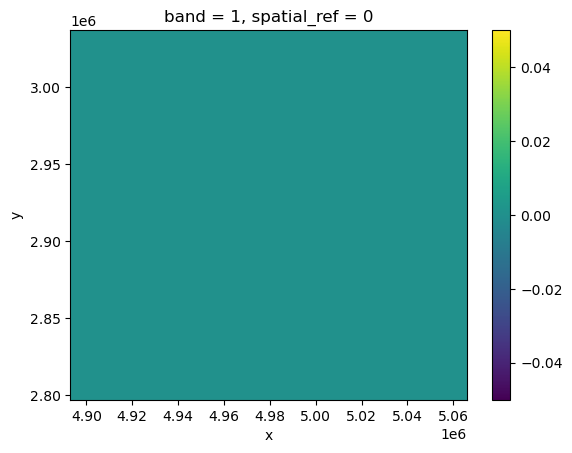

In [31]:
damagemap = rxr.open_rasterio('scenario_damagemap.tif')
damagemap.plot()

## Conclusions

Some text about conclusions and lessons learned

## Contributors
authors, links to libraries documentation, references etc